## Master's Thesis - Machine Learning in Asset Pricing

### Thomas Theodor Kjølbye 

The Following script handles all data used in the paper. On my computer, the entire script takes approximately 5 minutes to run. The data consist of individual firm characteristics as well as macroeconomic variables and are generously made available by Professors Gu, Kelly, Xiu, and Goyal. 

The script is the 2nd of two data processing scripts. The first one does not compute interaction terms or reduce dimensionality by PCA. However, it does perform the rank normalization leveraged in Gu, Kelly, and Xiu (2020). 

In [1]:
# Load the usual suspects
import csv
import pandas as pd
import numpy as np
import os
import Toolbox as tb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

In [ ]:
# Initialize warning log container 
log = list()

In [ ]:
os.getcwd()

In [ ]:
# Load monthly returns data from CRSP and process data
returns = pd.read_csv(os.path.dirname(os.getcwd()) + '\\RET.txt')
returns.columns = returns.columns.str.strip()
returns.columns = returns.columns.str.lower() 
returns.rename(columns = {"col1":"date"}, inplace = True)
returns["date"] = returns["date"].floordiv(100)
returns_raw = returns[["date", "permno", "ret"]]

# Load macroeconomic predictors and clean it
macro_data_raw = pd.read_csv(os.path.dirname(os.getcwd()) + '\\macro_data.csv') 
macro_data_raw = macro_data_raw[(macro_data_raw["date"] > 195612) & (macro_data_raw["date"] < 201701)]
macro_data_raw["constant"] = 1 # Add column of ones for interaction terms later

# Load firm characteristics
firm_data_raw = pd.read_csv(os.path.dirname(os.getcwd()) + '\\datashare.zip')
firm_data_raw.columns = firm_data_raw.columns.str.lower()
firm_data_raw["date"] = firm_data_raw["date"].floordiv(100) # https://stackoverflow.com/questions/33034559/how-to-remove-last-the-two-digits-in-a-column-that-is-of-integer-type
firm_data_raw.set_index(["permno", "date"], inplace = True)
print("The firm characteristics dataset is {:1.3f} GB".format(firm_data_raw.memory_usage().sum()/(1024 ** 3)))

# I have refrained from saving the firm char. in my wd (repo) because I am unable to push 3 GB worth of data to the github.

In [ ]:
# Downcast from 64bit flots and ints to 32bit
tb.downcast(firm_data_raw)
tb.downcast(returns_raw)
tb.downcast(macro_data_raw)

In [ ]:
# Filter out rows missing in returns data by merging
data = firm_data_raw.reset_index().merge(returns_raw, on = ["permno", "date"], how = "inner")

# Scale macroeconomic data to same shape as other data by merging
data = data.merge(macro_data_raw, on = "date")
data = data.set_index(["permno", "date"]) # 3760315 x 105 (94 char, industry dummy, returns, 8 macro, ones)

In [ ]:
# Separate dataset in 1) firm chars + macro (FM), 2) returns, and 3) industry codes

# 1)
FM_todrop = ["ret", "sic2"]
FM_data = data.drop(FM_todrop, axis = 1).reset_index()

# 2) 
returns = data.ret.reset_index()

# 3) 
industry_code = data.sic2.reset_index()

In [ ]:
# Save data
FM_data.to_csv(os.path.dirname(os.getcwd()) + '\\FM_data.csv', header = True, index = False)
returns.to_csv(os.path.dirname(os.getcwd()) + '\\returns_data.csv', header = True, index = False)
industry_code.to_csv(os.path.dirname(os.getcwd()) + '\\industry_codes.csv', header = True, index = False)

In [8]:
### NOTE: Above code can be ignored once FM_data.csv has been saved to disc

# Load FM data
FM_data = pd.read_csv(os.path.dirname(os.getcwd()) + '\\FM_data.csv')
returns = pd.read_csv(os.path.dirname(os.getcwd()) + '\\returns_data.csv').set_index(["permno", "date"])
industry_code = pd.read_csv(os.path.dirname(os.getcwd()) + '\\industry_codes.csv').set_index(["permno", "date"])

tb.downcast(FM_data)
tb.downcast(returns)
tb.downcast(industry_code)

Before downcast: 2.942 GB and float64    102
int64        3
dtype: int64
After downcast: 1.460 GB and float32    102
int32        2
int8         1
dtype: int64
Before downcast: 0.043 GB and float64    1
dtype: int64
After downcast: 0.029 GB and float32    1
dtype: int64
Before downcast: 0.043 GB and float64    1
dtype: int64
After downcast: 0.029 GB and float32    1
dtype: int64


In [9]:
# Stats
FM_data.permno.unique().shape # 29906 unique firms
avg = [x.shape[0] for x in FM_data.groupby("date").permno.unique()]
sum(avg)/len(avg) # 5222.66 firms on average at each point in time (month)


5222.659722222223

In [3]:
# Dates partitioning the training, validation, and test set (10 folds in the forward chaining)
tv_dates = [197501, 197601, 197701, 197801, 197901, 198001, 198101, 198201, 198301, 198401]
v_dates = [197801, 197901, 198001, 198101, 198201, 198301, 198401, 198501, 198601, 198701]
t_dates = [198701, 198701, 198701, 198701, 198701, 198701, 198701, 198701, 198701, 198701]

tv_dates = tv_dates[0]
v_dates = v_dates[0]
t_dates = t_dates[0]

In [4]:
# Split data according to selected dates and drop columns based on correlation
tfirm, vfirm, ttfirm, tmacro, vmacro, ttmacro = tb.data_processing(data = FM_data, TV_date = tv_dates, 
                                                                   V_date = v_dates, T_date = t_dates)

In [5]:
# Compute interaction terms for training and validation data
interaction_t, mean, std = tb.interaction(tfirm, tmacro)
interaction_v, _, _ = tb.interaction(vfirm, vmacro)

In [7]:
# Compute interaction terms for test data 
tb.interaction_noRAM(ttfirm, ttmacro, mean = mean, std = std, filename = 'interaction_tt.csv')

In [8]:
# PCA: Training data
pca = PCA(n_components = 0.95)
pca.fit(interaction_t)

# PCA keeping only principal components with eigenvalues greater than 1
pca_transform = pca.components_[:pca.explained_variance_[pca.explained_variance_ >= 1].shape[0], :]
pca_data_t = np.dot(interaction_t, pca_transform.T) # NxK @ KxP = NxP
name = ['PC' + str(x) for x in range(1, pca_data_t.shape[1]+1)]
pca_data_t = pd.DataFrame(pca_data_t, columns = name )


# PCA: Validation data
pca_data_v = np.dot(interaction_v, pca_transform.T) # NxK @ KxP = NxP
pca_data_v = pd.DataFrame(pca_data_v, columns = name)

'''
# PCA with all principal components
pca_data_t = pca.transform(interaction_t) 
pca_data_t = pd.DataFrame(pca_data_t)


# PCA: Validation data
pca_data_v = pca.transform(interaction_v)
pca_data_v = pd.DataFrame(pca_data_v)

'''

# pca.components_ returns the eigenvectors
# pca.explained_variance_ returns the eigenvalues

'\n# PCA with all principal components\npca_data_t = pca.transform(interaction_t) \npca_data_t = pd.DataFrame(pca_data_t)\n\n\n# PCA: Validation data\npca_data_v = pca.transform(interaction_v)\npca_data_v = pd.DataFrame(pca_data_v)\n\n'

In [9]:
# PCA: Test data
tb.save_txt(name = os.path.dirname(os.getcwd()) + "\\" + 'interaction_tt.csv', newfilename = 'pca_data_tt.csv',
                    pc = pca_transform)

In [10]:
# Load test data post PCA
pca_data_tt = pd.read_csv(os.path.dirname(os.getcwd()) + "\\pca_data_tt.csv", header = None)
pca_data_tt.columns = name
tb.downcast(pca_data_tt) # 2.753 GB, 1.377 GB efter

Before downcast: 1.326 GB and float64    71
dtype: int64
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
After downcast: 0.663 GB and float32    71
dtype: int64


In [11]:
# Prep industry codes for merge with remainder of predictors (covariates)
industry_dummies_t, industry_dummies_v, industry_dummies_tt = tb.dummies(data = industry_code, TV_date = tv_dates, 
                                                                         V_date = v_dates, T_date = t_dates)

# Prep returns data for merge with predictors (covariates)
returns_t = returns[returns.index.get_level_values("date") < tv_dates].reset_index()
returns_v = returns[(returns.index.get_level_values("date") >= tv_dates) & 
                                                  (returns.index.get_level_values("date") < v_dates)].reset_index()
returns_tt = returns[returns.index.get_level_values("date") >= t_dates].reset_index()


In [12]:
# Merge data and save to disc

# Training
data_t = pd.concat([pca_data_t, industry_dummies_t], axis = 1)
data_t = data_t.merge(returns_t, on = ["permno", "date"], how = "inner").set_index(["permno", "date"])
data_t.to_csv(os.path.dirname(os.getcwd()) + '\\Data' +'\\data_t_01.csv', header = True, index = True)

# Validation
data_v = pd.concat([pca_data_v, industry_dummies_v], axis = 1)
data_v = data_v.merge(returns_v, on = ["permno", "date"], how = "inner").set_index(["permno", "date"])
data_v.to_csv(os.path.dirname(os.getcwd()) + '\\Data' +'\\data_v_01.csv', header = True, index = True)

# Test
data_tt = pd.concat([pca_data_tt, industry_dummies_tt], axis = 1)
data_tt = data_tt.merge(returns_tt, on = ["permno", "date"], how = "inner").set_index(["permno", "date"])
data_tt.to_csv(os.path.dirname(os.getcwd()) + '\\Data' +'\\data_tt_01.csv', header = True, index = True)

In [ ]:
# Skal jeg tjekke at søjlerne efter PCA har mean 0 og std 1? skal de jo gerne have tænker jeg
# jeg kan lave en pipeline a la det ham duden gjorde med alle modellerne. Det skal jeg så bare have ind i et loop

In [ ]:
# Prep data for PCA figure
import itertools as it

explained_var_sum = it.accumulate(pca.explained_variance_ratio_)
explained_var_sum_list = list(explained_var_sum)
#explained_var_sum_list = explained_var_sum_list[:pca.explained_variance_[pca.explained_variance_ >= 1].shape[0]]

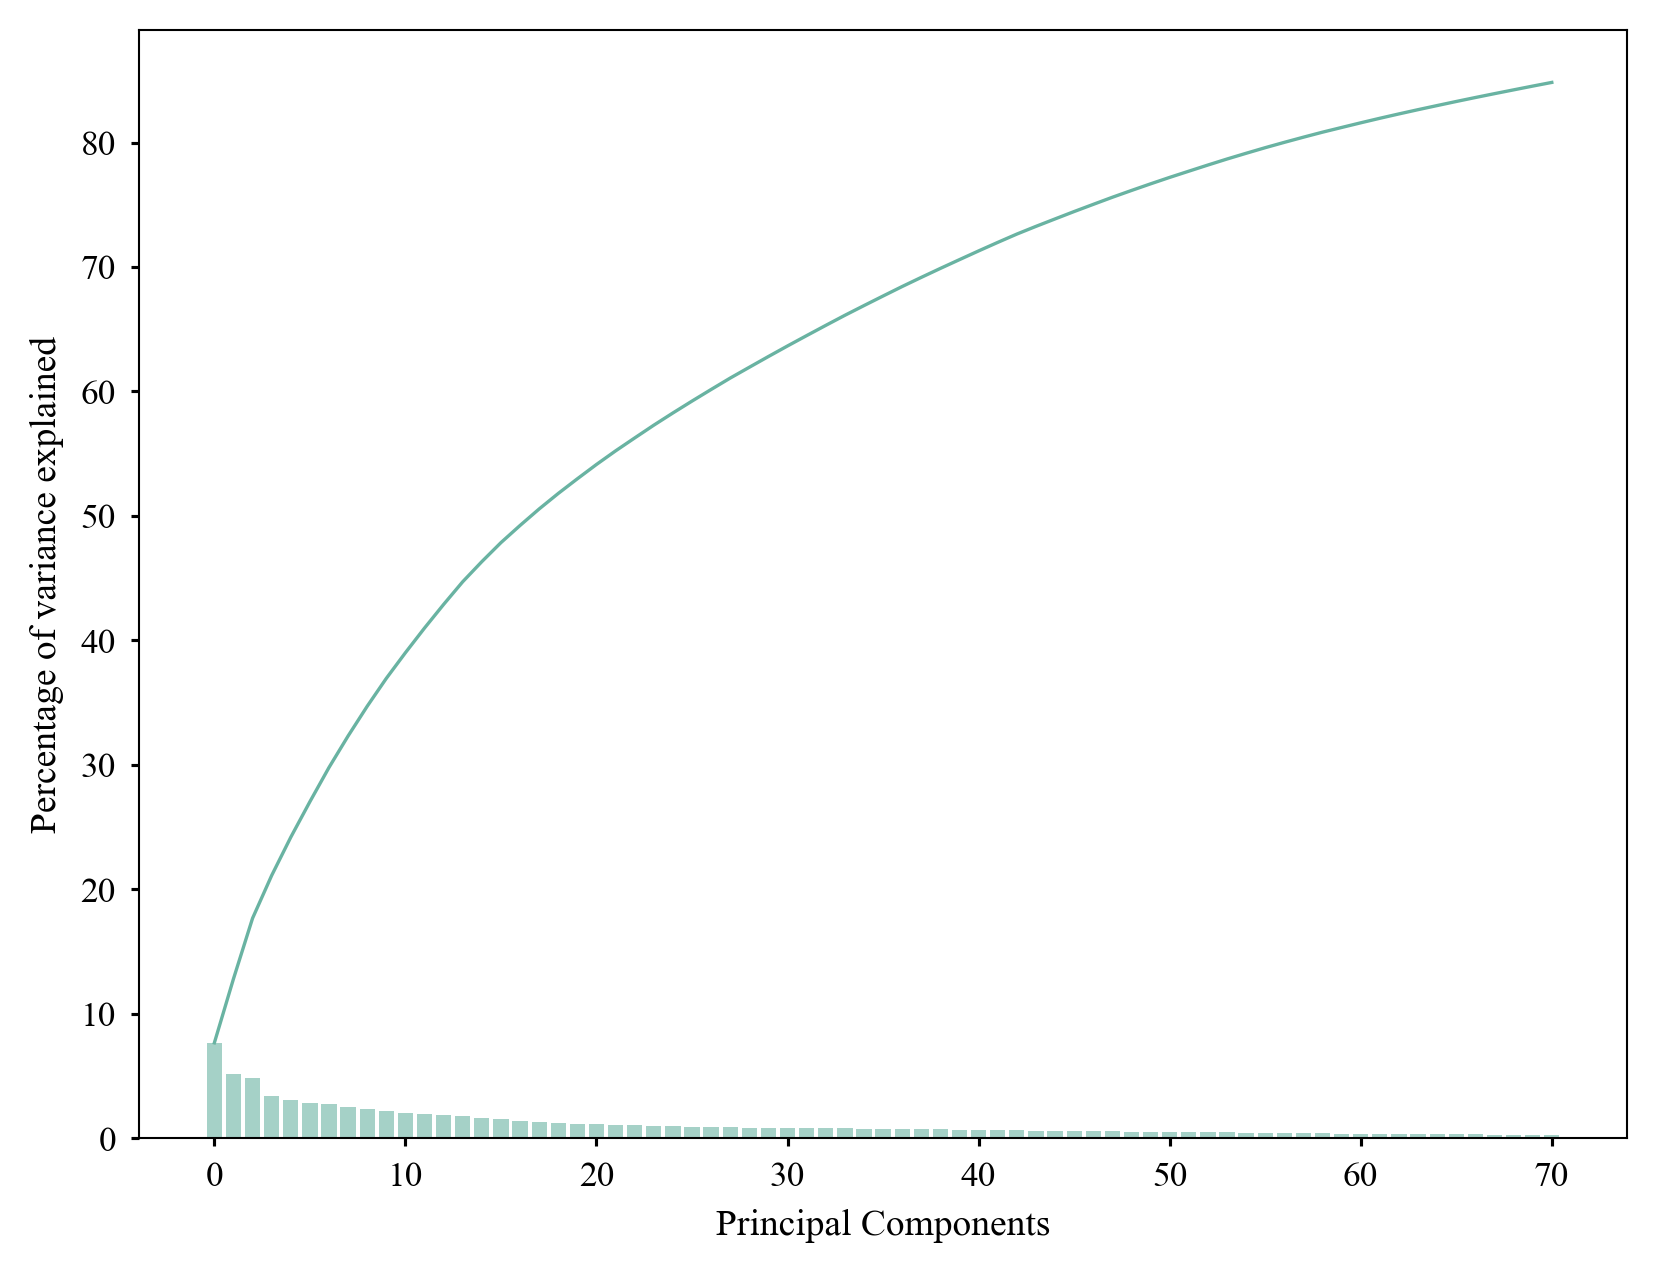

In [162]:
# Setup PCA Figure
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "Times New Roman"
dim = pca.explained_variance_[pca.explained_variance_ >= 1].shape[0]
height = pca.explained_variance_ratio_[:dim]*100
bars = ['PC' + str(x) for x in range(1, dim+1)]
x_pos = (np.arange(len(explained_var_sum_list[:dim])))

# PCA Figure
fig, ax = plt.subplots()
ax.bar(x_pos, height, color = "#69b3a2", alpha = 0.6)
ax.plot([item * 100 for item in explained_var_sum_list[:dim]], color = "#69b3a2", linewidth = 0.8, alpha = 1)

# Slim axes
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
ax.spines['top'].set_linewidth(0.5)

# Smaller tick text and smaller ticks
ax.tick_params(axis='both', which='major', labelsize=8.5, width = 0.75, length = 2)

# Add labels and change font 
plt.xlabel("Principal Components", size = 9)
plt.ylabel("Percentage of variance explained", size = 9)

# Save as PDF
plt.savefig('pca_test.pdf', bbox_inches='tight')

plt.show()

In [ ]:
Pæne figurer: 
# https://www.python-graph-gallery.com/line-chart/
# https://seaborn.pydata.org/tutorial/color_palettes.html